In [1]:
import numpy as np 
import pandas as pd
import os

import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import style
style.use('ggplot')

import seaborn as sns
sns.set()

from IPython.display import HTML
display(HTML("<style>.container { width:98% !important; }</style>"))

import timeit
from tqdm import tqdm

from ipywidgets import interact
import ipywidgets as widgets

from scipy import fftpack

from os import listdir
print(listdir("../input"))

['test', 'train.csv', 'sample_submission.csv']


In [2]:
train_nrows = !wc -l ../input/train.csv
train_nrows_val = int(train_nrows[0].split()[0])
print('train.csv contains {:,} rows'.format(train_nrows_val))

train.csv contains 629,145,481 rows


In [3]:
!head ../input/train.csv

acoustic_data,time_to_failure
12,1.4690999832
6,1.4690999821
8,1.469099981
5,1.4690999799
8,1.4690999788
8,1.4690999777
9,1.4690999766
7,1.4690999755
-5,1.4690999744


### TTF Precision - Check MAX precision

In [7]:
start_time = timeit.default_timer()
max_precision = 0
count = 0
with open('../input/train.csv', 'r') as f:
    while count<10: #True: #count <10:
        line = f.readline()
        if not line: 
            break
        else: 
            print(line.rstrip())
            if count > 0:
                print(line[:-1].split('.')[1])
                if '.' in line: 
                    str_len = len(line[:-1].split('.')[1])
                    print(str_len)
                    if max_precision < str_len:
                        print(line)
                    max_precision = max_precision if max_precision > str_len else str_len
                print(line)
                print(line.split('.')[1])
        count +=1
print (max_precision)
print('elapsed time: {:.2f} sec'.format(timeit.default_timer()-start_time))

acoustic_data,time_to_failure
12,1.4690999832
4690999832
10
12,1.4690999832

12,1.4690999832

4690999832

6,1.4690999821
4690999821
10
6,1.4690999821

4690999821

8,1.469099981
469099981
9
8,1.469099981

469099981

5,1.4690999799
4690999799
10
5,1.4690999799

4690999799

8,1.4690999788
4690999788
10
8,1.4690999788

4690999788

8,1.4690999777
4690999777
10
8,1.4690999777

4690999777

9,1.4690999766
4690999766
10
9,1.4690999766

4690999766

7,1.4690999755
4690999755
10
7,1.4690999755

4690999755

-5,1.4690999744
4690999744
10
-5,1.4690999744

4690999744

10
elapsed time: 0.06 sec


In [8]:
column_names = !head -n1 ../input/train.csv
print(column_names[0].split(','))

['acoustic_data', 'time_to_failure']


In [9]:
df_train_sample = pd.read_csv('../input/train.csv', skiprows = 0, nrows=100,
                       dtype={'acoustic_data': np.int16, 'time_to_failure': np.float64}) 

In [10]:
def display_df_with_preset_precision(df, precision):
    curr_precision = pd.get_option("display.precision")
    pd.set_option("display.precision", precision)
    display(df)
    pd.set_option("display.precision", curr_precision)
    
display_df_with_preset_precision(df_train_sample.head(9), max_precision)

,acoustic_data,time_to_failure
0,12,1.4690999832
1,6,1.4690999821
2,8,1.4690999810
3,5,1.4690999799
4,8,1.4690999788
5,8,1.4690999777
6,9,1.4690999766
7,7,1.4690999755
8,-5,1.4690999744


In [11]:
try:
    del(df_train_sample)    
except NameError:
    pass

In [12]:
start_time = timeit.default_timer()
from collections import Counter
diff_ttf_2_counter_dict = Counter()
try:
    del(df_train_iter)    
except NameError:
    pass
df_train_iter = pd.read_csv('../input/train.csv', chunksize=train_nrows_val//100,
                       dtype={'acoustic_data': np.int16, 'time_to_failure': np.float64},iterator=True)
time_to_failure_diffs_set = set()
df_after_jumping_up_points = pd.DataFrame()
df_after_long_jumps_down_points=pd.DataFrame()
for df in df_train_iter:
    df['diff_in_time_to_failure']=df['time_to_failure'].diff()
    nparr_ = df['diff_in_time_to_failure'].values
    nparr_ = nparr_[~np.isnan(nparr_)]
    diff_ttf_2_counter_dict += Counter(nparr_)

    df_jumps_up = df.loc[(df['diff_in_time_to_failure'] > 0)]
    df_long_jumps_down = df.loc[(df['diff_in_time_to_failure'] < -0.0001)]
    df_after_jumping_up_points=df_after_jumping_up_points.append(df_jumps_up)
    df_after_long_jumps_down_points=df_after_long_jumps_down_points.append(df_long_jumps_down)
print('elapsed time: {:.2f} sec'.format(timeit.default_timer()-start_time))

elapsed time: 307.33 sec


In [13]:
len(list(diff_ttf_2_counter_dict.keys()))

451

In [14]:
diff_ttf_2_counter_dict

Counter({-1.0999998689698032e-09: 25318543,
         -1.100000313059013e-09: 4893808,
         -1.0999996469251982e-09: 26651657,
         -1.100000091014408e-09: 363912910,
         -0.0009954954999999988: 5893,
         -0.0010954954999997657: 1169,
         -0.0010954954999999877: 22199,
         -0.0009954954999997767: 17243,
         -0.001095495479999875: 2,
         -1.0999999799921056e-09: 36789889,
         -1.1000002020367106e-09: 363297,
         -0.0009954954999998877: 545,
         -0.0010954954999998767: 571,
         -0.0010954955000000988: 517,
         -0.0009954955000001098: 263,
         -1.1000000355032569e-09: 5120202,
         -0.0009954955000000543: 328,
         -0.0010954955000000433: 753,
         -0.0010954955000000155: 617,
         -1.1000000077476813e-09: 5024997,
         -0.0009954955000000265: 129,
         -0.00109549549999996: 164,
         -1.0999999938698934e-09: 2781206,
         -1.100000021625469e-09: 266318,
         -0.0010954955000000016: 439,

In [15]:
# positive jumps
{k: v for k, v in diff_ttf_2_counter_dict.items() if k>0}

{11.54000450717705: 1,
 14.17990450782529: 1,
 8.85590450633608: 1,
 12.6929045071319: 1,
 8.0549045061459: 1,
 7.057904505904601: 1,
 16.106904507467007: 1,
 7.904904506085151: 1,
 9.63690450647408: 1,
 11.42590450661124: 1,
 11.02400450628308: 1,
 8.828004506336834: 1,
 8.565904506238308: 1,
 14.75090450749273: 1,
 9.45890450638701: 1,
 11.6180045065607: 1}

In [16]:
10.**max_precision

10000000000.0

In [17]:
negative_diff_tff_2_counter_dict = Counter()

In [18]:
for k, v in diff_ttf_2_counter_dict.items():
    if k<=0:
        negative_diff_tff_2_counter_dict[int(-k*(10.**max_precision))] += v 
negative_diff_tff_2_counter_dict

Counter({10: 190859716,
         11: 405650006,
         9954954: 27393,
         10954954: 51479,
         10954955: 32699,
         9954955: 19968,
         10954966: 34,
         19: 1805636,
         9: 23499054,
         20: 7177368,
         10954949: 3629,
         9954949: 2423,
         10954950: 1425,
         9954950: 425,
         10954960: 1438,
         10954953: 2,
         9954966: 18,
         10954969: 8,
         10954970: 4,
         10954965: 26,
         9954965: 23,
         10954959: 7534,
         9954959: 4448,
         9954960: 600,
         9954969: 3,
         10954956: 1,
         10954958: 1,
         14: 1,
         9954956: 1})

In [19]:
#time diff within sampling frames
time_diff_within_sampling_frames_2_count_dict = {k: v for k, v in negative_diff_tff_2_counter_dict.items() if k<100}
time_diff_within_sampling_frames_2_count_dict

{10: 190859716, 11: 405650006, 19: 1805636, 9: 23499054, 20: 7177368, 14: 1}

In [20]:
#time diff between sampling frames
time_diff_between_sampling_frames_2_count_dict = {round(k/(10.**max_precision),6): v for k, v in negative_diff_tff_2_counter_dict.items() if k>=100}
time_diff_between_sampling_frames_2_count_dict

{0.000995: 1, 0.001095: 1}

In [21]:
print(df_after_jumping_up_points.shape)
display_df_with_preset_precision(df_after_jumping_up_points, max_precision)

(16, 3)


,acoustic_data,time_to_failure,diff_in_time_to_failure
5656574,4,11.5407999870,11.5400045072
50085878,1,14.1805999900,14.1799045078
104677356,4,8.8566999914,8.8559045063
138772453,-4,12.6939999940,12.6929045071
187641820,2,8.0554999956,8.0549045061
218652630,4,7.0589999970,7.0579045059
245829585,2,16.1074000000,16.1069045075
307838917,2,7.9056000019,7.9049045061
338276287,3,9.6371000039,9.6369045065
375377848,0,11.4264000060,11.4259045066


In [22]:
display_df_with_preset_precision(df_after_long_jumps_down_points.head(),max_precision)

,acoustic_data,time_to_failure,diff_in_time_to_failure
4095,-13,1.4680999843,-0.0009954955
8191,-2,1.4669999843,-0.0010954955
12287,-4,1.4658999843,-0.0010954955
16383,0,1.4648999843,-0.0009954955
20479,3,1.4637999843,-0.0010954955


In [23]:
np.unique(np.diff(df_after_long_jumps_down_points.index))

array([4095, 4096, 8192])

In [24]:
len(np.where(np.diff(df_after_long_jumps_down_points.index)==8192)[0])

17

In [25]:
len(np.where(np.diff(df_after_long_jumps_down_points.index)==4095)[0])

119

In [26]:
len(np.where(np.diff(df_after_long_jumps_down_points.index)==4096)[0])

153445

In [27]:
max(time_diff_within_sampling_frames_2_count_dict.keys())/(10.**max_precision)*8192

1.6384e-05

In [28]:
np.mean(list(time_diff_between_sampling_frames_2_count_dict.keys()))

0.001045

In [29]:
(max(time_diff_within_sampling_frames_2_count_dict.keys())/(10.**max_precision)*8192)/np.mean(list(time_diff_between_sampling_frames_2_count_dict.keys()))

0.015678468899521535

In [30]:
start_time = timeit.default_timer()
try:
    del(df_train_iter)    
except NameError:
    pass

df_train_iter = pd.read_csv('../input/train.csv', chunksize=train_nrows_val//100,
                       dtype={'acoustic_data': np.int16, 'time_to_failure': np.float64},iterator=True) #use chunksize to iterate
df_before_jumping_up_points = pd.DataFrame()
for df in df_train_iter:
    if len(df.index.intersection(df_after_jumping_up_points.index-1)) > 0:
        try:
            df_before_jumping_up_points=df_before_jumping_up_points.append(df.loc[df.index.intersection(df_after_jumping_up_points.index-1),:])
        except KeyError:
            print('KeyError')
            pass
print('elapsed time: {:.2f} sec'.format(timeit.default_timer()-start_time))

elapsed time: 156.71 sec


In [31]:
print(df_before_jumping_up_points.shape)
df_before_jumping_up_points

(16, 2)


,acoustic_data,time_to_failure
5656573,4,0.000795
50085877,8,0.000695
104677355,6,0.000795
138772452,3,0.001095
187641819,7,0.000595
218652629,5,0.001095
245829584,1,0.000495
307838916,7,0.000695
338276286,4,0.000195
375377847,0,0.000495


In [33]:
start_time = timeit.default_timer()

try:
    del(df_train_tail)    
except NameError:
    pass
df_train_tail = pd.read_csv('../input/train.csv', skiprows = train_nrows_val-100000, iterator=False, names=column_names[0].split(','))
df_train_tail['acoustic_data'] = df_train_tail['acoustic_data'].astype(np.int16)
df_train_tail['time_to_failure'] = df_train_tail['time_to_failure'].astype(np.float64)
print('elapsed time: {:.2f} sec'.format(timeit.default_timer()-start_time))

elapsed time: 35.37 sec


In [34]:
df_train_tail.tail()

,acoustic_data,time_to_failure
99995,7,9.759796
99996,9,9.759796
99997,10,9.759796
99998,6,9.759796
99999,5,9.759796


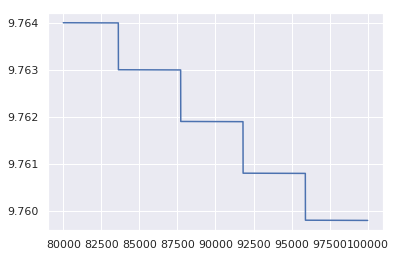

In [35]:
# TTF steps
df_train_tail.tail(20000)['time_to_failure'].plot();

In [36]:
start_time = timeit.default_timer()

try:
    del(df_train_head)    
except NameError:
    pass
df_train_head = pd.read_csv('../input/train.csv', skiprows = 0, nrows = 100000, iterator=False)

print('elapsed time: {:.2f} sec'.format(timeit.default_timer()-start_time))

elapsed time: 0.03 sec


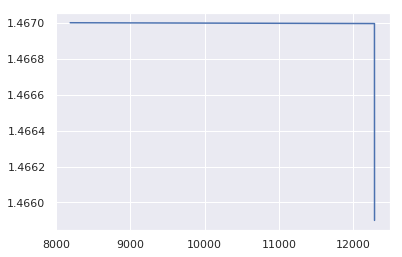

In [37]:
# TTF step in the first section
df_train_head.head(20000)[8192:8192+4096]['time_to_failure'].plot();

In [38]:
set(df_train_head.head(20000)[8192:8192+4095]['time_to_failure'].diff())

{nan,
 -1.100000313059013e-09,
 -1.100000091014408e-09,
 -1.0999998689698032e-09,
 -1.0999996469251982e-09}

In [39]:
n=0
set(df_train_head.head(2000000)['time_to_failure'].diff())

{nan,
 -0.0010954954999999877,
 -0.0010954954999997657,
 -0.0009954954999999988,
 -0.0009954954999997767,
 -1.100000313059013e-09,
 -1.100000091014408e-09,
 -1.0999998689698032e-09,
 -1.0999996469251982e-09}

In [40]:
index_ranges = [(ent[0],ent[1]) for ent in zip([0]+list(df_after_jumping_up_points.index)[:-1],list(df_before_jumping_up_points.index))]
index_ranges

[(0, 5656573),
 (5656574, 50085877),
 (50085878, 104677355),
 (104677356, 138772452),
 (138772453, 187641819),
 (187641820, 218652629),
 (218652630, 245829584),
 (245829585, 307838916),
 (307838917, 338276286),
 (338276287, 375377847),
 (375377848, 419368879),
 (419368880, 461811622),
 (461811623, 495800224),
 (495800225, 528777114),
 (528777115, 585568143),
 (585568144, 621985672)]

In [41]:
train_set_lengths =np.array([ent[1]-ent[0] for ent in zip([0]+list(df_before_jumping_up_points.index)[:-1],list(df_before_jumping_up_points.index))])
train_set_lengths

array([ 5656573, 44429304, 54591478, 34095097, 48869367, 31010810,
       27176955, 62009332, 30437370, 37101561, 43991032, 42442743,
       33988602, 32976890, 56791029, 36417529])

In [42]:
train_set_lengths.mean(), train_set_lengths.std()

(38874104.5, 13078782.58174961)

RangeIndex(start=0, stop=34095096, step=1)


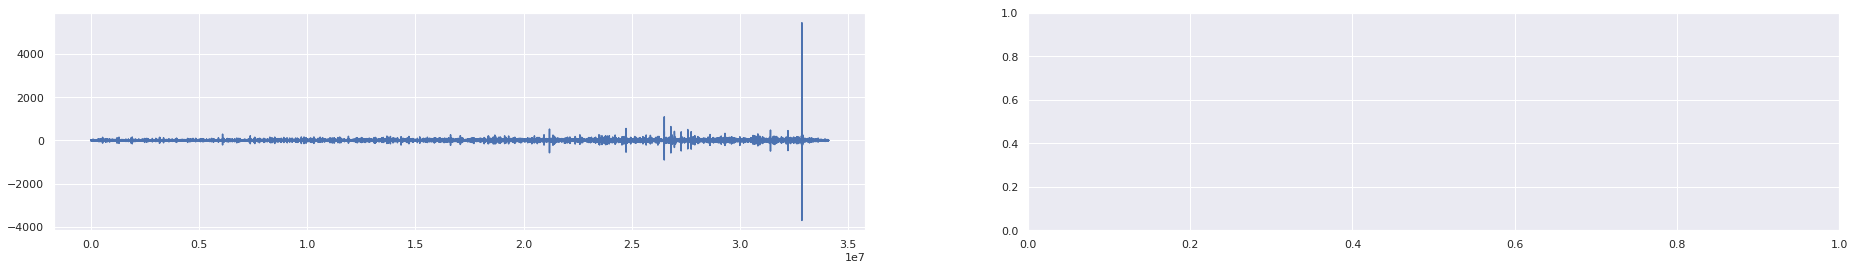

elapsed time: 29.00 sec


In [43]:
range_index = 3
window_size = 15000
window_offset = -window_size
start_time = timeit.default_timer()
try:
    del(df_sample)    
except NameError:
    pass
df_sample = pd.read_csv('../input/train.csv', skiprows = index_ranges[range_index][0], nrows= index_ranges[range_index][1]-index_ranges[range_index][0],
                       dtype={'acoustic_data': np.int16, 'time_to_failure': np.float64})
df_sample.columns=['acoustic_data','time_to_failure']
print(df_sample.index)

fig, axs = plt.subplots(nrows=1, ncols=2, sharex=False)
fig.set_size_inches(32,4)
df_sample['acoustic_data'].plot(ax=axs[0]);
plt.show()
df_sample['time_to_failure'].plot(ax=axs[1]);
plt.show()
print('elapsed time: {:.2f} sec'.format(timeit.default_timer()-start_time))

In [44]:
max_time_to_failure_points = pd.read_csv('../input/train.csv', skiprows = 0, nrows= 1, dtype={'acoustic_data': np.int16, 'time_to_failure': np.float64})['time_to_failure'].append(df_after_jumping_up_points['time_to_failure'])
max_time_to_failure_points

0             1.4691
5656574      11.5408
50085878     14.1806
104677356     8.8567
138772453    12.6940
187641820     8.0555
218652630     7.0590
245829585    16.1074
307838917     7.9056
338276287     9.6371
375377848    11.4264
419368880    11.0242
461811623     8.8281
495800225     8.5660
528777115    14.7518
585568144     9.4595
621985673    11.6186
Name: time_to_failure, dtype: float64

In [45]:
max_time_to_failure_points.values[:-1]

array([ 1.46909998, 11.54079999, 14.18059999,  8.85669999, 12.69399999,
        8.0555    ,  7.059     , 16.1074    ,  7.9056    ,  9.6371    ,
       11.42640001, 11.02420001,  8.82810001,  8.56600001, 14.75180002,
        9.45950002])

In [46]:
decline_angle_tangents = np.array([ent[0]/ent[1] for ent in zip(max_time_to_failure_points.values[:-1], max_time_to_failure_points.index[1:])])
print(decline_angle_tangents.mean())
print(decline_angle_tangents.std())

6.559536110169193e-08
7.398732224660528e-08


In [47]:
try:
    del(df_sample)    
except NameError:
    pass

## EDA

In [48]:
test_seg_files = listdir("../input/test")
test_seg_files[:5]

['seg_0b082e.csv',
 'seg_9e7dff.csv',
 'seg_b6c10d.csv',
 'seg_4435bd.csv',
 'seg_c09a41.csv']

In [49]:
len(test_seg_files)

2624

In [50]:
os.path.join("../input/test",test_seg_files[0])

'../input/test/seg_0b082e.csv'

In [51]:
!wc -l {os.path.join("../input/test",test_seg_files[0])}

150001 ../input/test/seg_0b082e.csv


In [52]:
!head {os.path.join("../input/test",test_seg_files[0])}

acoustic_data
3
10
4
4
1
3
7
6
-1


In [53]:

def plot_test_seg_by_index(idx):
    df_test_seg = pd.read_csv(os.path.join("../input/test",test_seg_files[idx]), dtype={'acoustic_data': np.int16})
    (df_test_seg['acoustic_data']-df_test_seg['acoustic_data'].mean()).plot();

In [54]:
interact(plot_test_seg_by_index, idx=widgets.IntSlider(min=0,max=len(test_seg_files)-1,step=1,value=0));

interactive(children=(IntSlider(value=0, description='idx', max=2623), Output()), _dom_classes=('widget-intera…

In [55]:
# make sure that all seg files have the same length: 150,000 samples:
seg_files_lengths = !for filename in ../input/test/*; do wc -l $filename; done
{ent.split(' ')[0] for ent in seg_files_lengths}

{'150001'}

In [56]:
(max(time_diff_within_sampling_frames_2_count_dict.keys())/(10.**max_precision)*150000)

0.00030000000000000003

In [57]:
np.mean(list(time_diff_between_sampling_frames_2_count_dict.keys()))*(150000/4096)

0.03826904296875

## Correlations

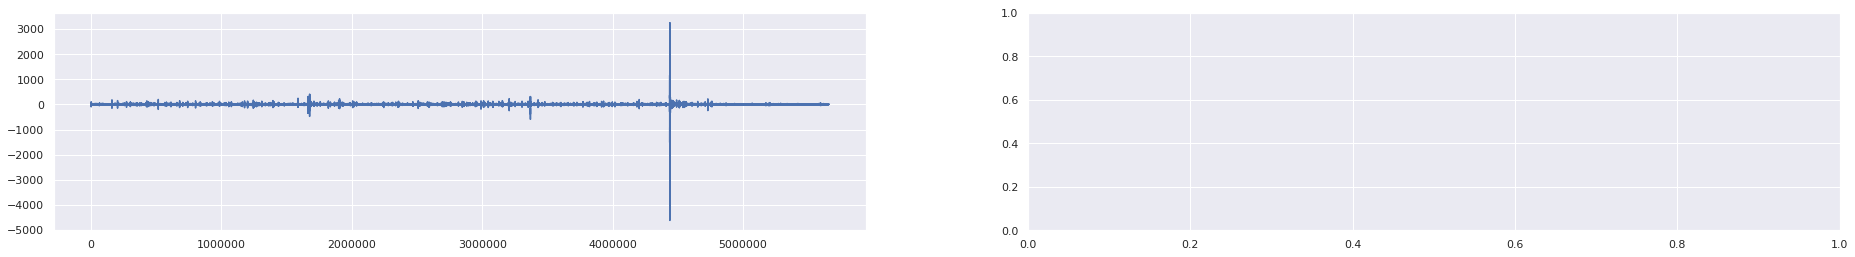

time_to_failure decline rate = 0.0000002597155527
elapsed time: 4.18 sec


In [58]:
start_time = timeit.default_timer()
try:
    del(df_sample)    
except NameError:
    pass

range_index=0 #first training sequence is the shortest one
df_sample = pd.read_csv('../input/train.csv', skiprows = index_ranges[range_index][0], nrows= index_ranges[range_index][1]-index_ranges[range_index][0],
                       dtype={'acoustic_data': np.int16, 'time_to_failure': np.float64})
df_sample.columns=['acoustic_data','time_to_failure']

fig, axs = plt.subplots(nrows=1, ncols=2, sharex=False)
fig.set_size_inches(32,4)
df_sample['acoustic_data'].plot(ax=axs[0]);
plt.show()
print ('time_to_failure decline rate = {:.16f}'.format(df_sample['time_to_failure'][0]/df_sample['time_to_failure'].shape[0]))
df_sample['time_to_failure'].plot(ax=axs[1]);
plt.show()
print('elapsed time: {:.2f} sec'.format(timeit.default_timer()-start_time))

In [59]:
df_sample['time_to_failure'][0]/df_sample['time_to_failure'].shape[0]

2.5971555272070207e-07

In [60]:
df_sample['time_to_failure'].shape[0]

5656573

In [61]:
df_sample['acoustic_data'].head()


0    12
1     6
2     8
3     5
4     8
Name: acoustic_data, dtype: int16

In [62]:
df_sample['acoustic_data'].mean()

4.560983125295121

In [63]:
train_values = (df_sample['acoustic_data']-df_sample['acoustic_data'].mean()).values
train_values

array([ 7.43901687,  1.43901687,  3.43901687, ..., -2.56098313,
       -0.56098313,  0.43901687])

In [64]:
df_test_seg = pd.read_csv(os.path.join("../input/test",test_seg_files[0]), dtype={'acoustic_data': np.int16})
df_test_seg.head()

,acoustic_data
0,3
1,10
2,4
3,4
4,1


In [65]:
df_test_seg['acoustic_data'].mean()

3.68208

In [66]:
test_values = (df_test_seg['acoustic_data']-df_test_seg['acoustic_data'].mean()).values

In [67]:
print(train_values.shape, test_values.shape)

(5656573,) (150000,)


In [68]:
from scipy import signal
signal_corr = signal.correlate(np.square(train_values), np.square(test_values),mode='valid', method='fft')

/opt/conda/lib/python3.6/site-packages/scipy/signal/signaltools.py:491: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return x[reverse].conj()


In [69]:
signal_corr.shape

(5506574,)

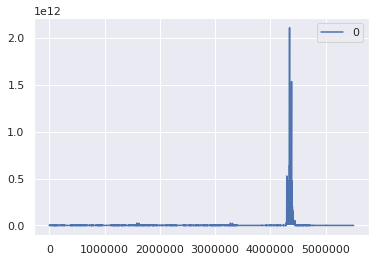

In [70]:
pd.DataFrame(signal_corr).plot()

In [72]:
def correlation_with_test_seg_idx(idx):
    df_test_seg = pd.read_csv(os.path.join("../input/test",test_seg_files[idx]), dtype={'acoustic_data': np.int16})
    test_values = (df_test_seg['acoustic_data']-df_test_seg['acoustic_data'].mean()).values
    signal_corr = signal.correlate(np.square(train_values), np.square(test_values),mode='same', method='fft')
    pd.DataFrame(signal_corr).plot();

In [73]:
interact(correlation_with_test_seg_idx, idx=widgets.IntSlider(min=0,max=len(test_seg_files)-1,step=1,value=0));

interactive(children=(IntSlider(value=0, description='idx', max=2623), Output()), _dom_classes=('widget-intera…

## Spectrogram

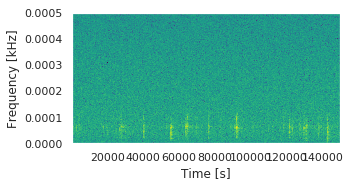

In [74]:
from scipy.signal import spectrogram

M = 1024
N = 1024
freqs, times, Sx = signal.spectrogram(df_test_seg['acoustic_data'].values, fs=1, window='hanning',
                                      nperseg=N, noverlap=M - 100,
                                      detrend=False, scaling='spectrum')

f, ax = plt.subplots(figsize=(4.8, 2.4))
ax.pcolormesh(times, freqs / 1000, 10 * np.log10(Sx), cmap='viridis')
ax.set_ylabel('Frequency [kHz]')
ax.set_xlabel('Time [s]');

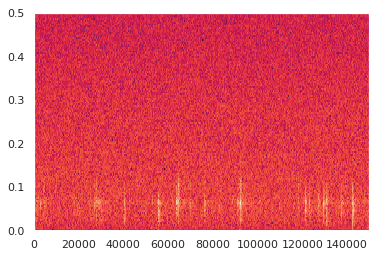

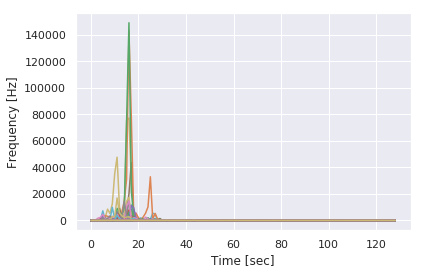

In [76]:
f, t, Sxx = spectrogram(df_test_seg['acoustic_data'].values)
plt.pcolormesh(t, f, 10 * np.log10(Sxx))
plt.show()
plt.plot(Sxx)
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.show()

In [77]:
from skimage import util

M = 1024

slices = util.view_as_windows(df_test_seg['acoustic_data'].values, window_shape=(M,), step=100)
print(f'data shape: {df_test_seg["acoustic_data"].values.shape}, Sliced data shape: {slices.shape}')

data shape: (150000,), Sliced data shape: (1490, 1024)


In [79]:
win = np.hanning(M + 1)[:-1]
slices = slices * win
slices = slices.T
print('Shape of `slices`:', slices.shape)
spectrum = np.fft.fft(slices, axis=0)[:M // 2 + 1:-1]
spectrum = np.abs(spectrum)

Shape of `slices`: (1024, 1490)


In [80]:
L=df_test_seg['acoustic_data'].values.shape[0]

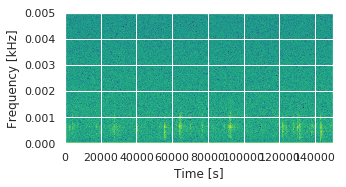

In [81]:
rate = 10
f, ax = plt.subplots(figsize=(4.8, 2.4))

S = np.abs(spectrum)
S = 20 * np.log10(S / np.max(S))

ax.imshow(S, origin='lower', cmap='viridis',
          extent=(0, L, 0, rate / 2 / 1000))
ax.axis('tight')
ax.set_ylabel('Frequency [kHz]')
ax.set_xlabel('Time [s]');

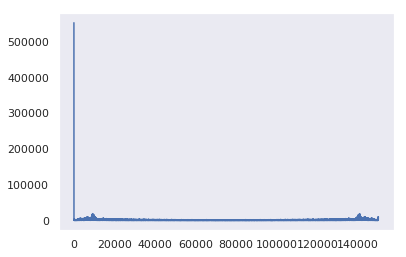

In [82]:
yf = fftpack.fft(df_test_seg['acoustic_data'].values)
plt.plot(np.abs(yf))
plt.grid()
plt.show()

### Fourier transform per sampling frame

In [83]:
display_df_with_preset_precision(df_after_long_jumps_down_points.head(),max_precision)

,acoustic_data,time_to_failure,diff_in_time_to_failure
4095,-13,1.4680999843,-0.0009954955
8191,-2,1.4669999843,-0.0010954955
12287,-4,1.4658999843,-0.0010954955
16383,0,1.4648999843,-0.0009954955
20479,3,1.4637999843,-0.0010954955


In [84]:
range_index=15 #first training sequence is the shortest one
start_time = timeit.default_timer()
try:
    del(df_sample)    
except NameError:
    pass
df_sample = pd.read_csv('../input/train.csv', skiprows = index_ranges[range_index][0], nrows= index_ranges[range_index][1]-index_ranges[range_index][0],
                       dtype={'acoustic_data': np.int16, 'time_to_failure': np.float64})
df_sample.columns=['acoustic_data','time_to_failure']
print('elapsed time: {:.2f} sec'.format(timeit.default_timer()-start_time))

elapsed time: 47.67 sec


In [85]:
df_sample.index
index_ranges[range_index]
ixs_of_indexes = np.where(np.all([df_after_long_jumps_down_points.index <= index_ranges[range_index][1],df_after_long_jumps_down_points.index >= index_ranges[range_index][0]-1],axis=0))[0]
ixs_of_indexes1 = np.where(np.logical_and(df_after_long_jumps_down_points.index <= index_ranges[range_index][1],
                        df_after_long_jumps_down_points.index >= index_ranges[range_index][0]))[0]
ixs_of_indexes,ixs_of_indexes1

(array([142945, 142946, 142947, ..., 151832, 151833, 151834]),
 array([142945, 142946, 142947, ..., 151832, 151833, 151834]))

In [86]:
np.array_equal(ixs_of_indexes1,ixs_of_indexes)

True

In [87]:
indexes = df_after_long_jumps_down_points.index[ixs_of_indexes].union(index_ranges[range_index])

In [88]:
np.unique(np.diff(indexes))

array([4095, 4096])

In [89]:
frame_indexes = list(zip(indexes[:-1],indexes[1:]))

In [90]:
len(list(frame_indexes))

8891

In [91]:
#MEAN (Bias) is removed 
low_path_filter_n_freqs = 2048
avg_len=1
frame_sequence_offset = -frame_indexes[0][0]
def show_frame_and_fft(sequence_idx):
    fig, axs = plt.subplots(nrows=1, ncols=3, sharex=False)
    the_df = df_sample[frame_sequence_offset+frame_indexes[sequence_idx][0]:frame_sequence_offset+frame_indexes[sequence_idx][1]]
    print(the_df.shape)
    diff_ttf = the_df['time_to_failure'].diff()[1:]    
    acustic_data_series = the_df['acoustic_data']
    
    print('ttf = {:.9f}'.format(the_df['time_to_failure'].mean()))
    print('diff_ttf.mean = {:.9f}, diff_ttf.std = {:.9f}'.format(diff_ttf.mean(), diff_ttf.std()))
    print('acustic.mean = {:.9f}, acustic.std = {:.9f}'.format(acustic_data_series.mean(), acustic_data_series.std()))
    
    (acustic_data_series - acustic_data_series.mean()).plot(ax=axs[0]);
    fig.set_size_inches(32,4)
    
    acustic_data_rft = fftpack.rfft(acustic_data_series-acustic_data_series.mean())
    acustic_data_ft = fftpack.fft(acustic_data_series-acustic_data_series.mean())
    
    rfreqs = fftpack.rfftfreq(acustic_data_rft.size,diff_ttf.mean())
    freqs = fftpack.fftfreq(acustic_data_ft.size, diff_ttf.mean())    
    rfreqs = -rfreqs
    
    the_dict = {}
    for idx in range(len(acustic_data_rft)):
        if rfreqs[idx] in the_dict:
            the_dict[rfreqs[idx]] = (the_dict[rfreqs[idx]]+np.abs(acustic_data_rft[idx]))/2.
        else: 
            the_dict[rfreqs[idx]] = np.abs(acustic_data_rft[idx])
    unique_rfreqs = np.unique(rfreqs)
    print("arrays are equal is {}".format(np.array_equal(sorted(unique_rfreqs),unique_rfreqs)))
    
    pd.DataFrame.from_dict({'acustic_data_rft_amp': [the_dict[ent] for ent in unique_rfreqs][:low_path_filter_n_freqs], 
                            'rfreqs':unique_rfreqs[:low_path_filter_n_freqs]}).set_index('rfreqs').plot(ax=axs[1])
    pd.DataFrame.from_dict({'acustic_data_ft_amp': (np.abs(acustic_data_ft)[len(freqs)//2:]), 
                            'freqs':freqs[len(freqs)//2:]}).set_index('freqs').plot(ax=axs[2])

In [92]:
print('range_index = {}'.format(range_index))
interact(show_frame_and_fft, sequence_idx=widgets.IntSlider(min=0,max=len(list(frame_indexes))-1,step=1,value=0));

range_index = 15


interactive(children=(IntSlider(value=0, description='sequence_idx', max=8890), Output()), _dom_classes=('widg…

In [93]:
def calc_fft_amp_per_sequence_index(sequence_idx):
    the_df = df_sample[frame_sequence_offset+frame_indexes[sequence_idx][0]:frame_sequence_offset+frame_indexes[sequence_idx][1]]

    diff_ttf = the_df['time_to_failure'].diff()[1:]   
    acustic_data_series = the_df['acoustic_data']
    
    print('ttf = {:.9f}'.format(the_df['time_to_failure'].mean()))
    print('diff_ttf.mean = {:.9f}, diff_ttf.std = {:.9f}'.format(diff_ttf.mean(), diff_ttf.std()))
    print('acustic.mean = {:.9f}, acustic.std = {:.9f}'.format(acustic_data_series.mean(), acustic_data_series.std()))    
    
    acustic_data_rft = fftpack.rfft(acustic_data_series-acustic_data_series.mean())
       
    rfreqs = -fftpack.rfftfreq(len(acustic_data_rft),diff_ttf.mean())   
    
    the_dict = {}
    for idx in range(len(acustic_data_rft)):
        if rfreqs[idx] in the_dict:
            the_dict[rfreqs[idx]] = (the_dict[rfreqs[idx]]+np.abs(acustic_data_rft[idx]))/2.
        else: 
            the_dict[rfreqs[idx]] = np.abs(acustic_data_rft[idx])
    
    unique_rfreqs = np.unique(rfreqs)
    
    return pd.DataFrame.from_dict({'acustic_data_rft_amp': [the_dict[ent] for ent in unique_rfreqs][:low_path_filter_n_freqs], 
                                   'rfreqs':unique_rfreqs[:low_path_filter_n_freqs]}).set_index('rfreqs')

In [94]:
(calc_fft_amp_per_sequence_index(0)['acustic_data_rft_amp']).values[:low_path_filter_n_freqs]

ttf = 9.459497765
diff_ttf.mean = -0.000000001, diff_ttf.std = 0.000000000
acustic.mean = 4.055419922, acustic.std = 2.667235273


array([  0.        , 390.57631821, 242.90575096, ...,  80.7214865 ,
        57.91800415,  16.89011352])

In [95]:
def features_row_per_sequence_index(sequence_idx):
    the_df = df_sample[frame_sequence_offset+frame_indexes[sequence_idx][0]:frame_sequence_offset+frame_indexes[sequence_idx][1]]

    diff_ttf = the_df['time_to_failure'].diff()[1:]   
    acustic_data_series = the_df['acoustic_data']   
    
    acustic_data_rft = fftpack.rfft(acustic_data_series-acustic_data_series.mean())
       
    rfreqs = -fftpack.rfftfreq(len(acustic_data_rft),diff_ttf.mean())   
    
    the_dict = {}
    for idx in range(len(acustic_data_rft)):
        if rfreqs[idx] in the_dict:
            the_dict[rfreqs[idx]] = (the_dict[rfreqs[idx]]+np.abs(acustic_data_rft[idx]))/2.
        else: 
            the_dict[rfreqs[idx]] = np.abs(acustic_data_rft[idx])
    
    unique_rfreqs = np.unique(rfreqs)
    
    return [acustic_data_series.mean()]+[the_dict[ent] for ent in unique_rfreqs][:low_path_filter_n_freqs][1:]+[the_df['time_to_failure'].mean()]

In [96]:
start_time = timeit.default_timer()
pd.DataFrame(np.array([features_row_per_sequence_index(idx) for idx in range(len(list(frame_indexes)))])).to_csv('../working/feat_rfft_data_for_range_index_{}_nfreqs_{}.csv'.format(range_index, low_path_filter_n_freqs))
print('elapsed time: {:.2f} sec'.format(timeit.default_timer()-start_time))

elapsed time: 125.05 sec


### Test frames

In [97]:
def plot_test_seg_by_index(idx):
    df_test_seg = pd.read_csv(os.path.join("../input/test",test_seg_files[idx]), dtype={'acoustic_data': np.int16})
    (df_test_seg['acoustic_data']-df_test_seg['acoustic_data'].mean()).plot();

In [98]:
#MEAN (Bias) is removed 
diff_ttf_mean = -0.000000001
avg_len=1
frame_sequence_offset = -frame_indexes[0][0]
def show_test_frame_and_fft_by_idx(idx):
    df_test_seg = pd.read_csv(os.path.join("../input/test",test_seg_files[idx]), dtype={'acoustic_data': np.int16})
    fig, axs = plt.subplots(nrows=1, ncols=3, sharex=False)

    print(df_test_seg.shape)
    
    acustic_data_series = df_test_seg['acoustic_data']
   
    print('acustic.mean = {:.9f}, acustic.std = {:.9f}'.format(acustic_data_series.mean(), acustic_data_series.std()))
    
    (acustic_data_series - acustic_data_series.mean()).plot(ax=axs[0]);

    fig.set_size_inches(32,4)
    
    acustic_data_rft = fftpack.rfft(acustic_data_series-acustic_data_series.mean())
    acustic_data_ft = fftpack.fft(acustic_data_series-acustic_data_series.mean())
    
    rfreqs = fftpack.rfftfreq(acustic_data_rft.size,diff_ttf_mean)
    freqs = fftpack.fftfreq(acustic_data_ft.size, diff_ttf_mean)
        
    rfreqs = -rfreqs
    
    the_dict = {}
    for idx in range(len(acustic_data_rft)):
        if rfreqs[idx] in the_dict:
            the_dict[rfreqs[idx]] = (the_dict[rfreqs[idx]]+np.abs(acustic_data_rft[idx]))/2.
        else: 
            the_dict[rfreqs[idx]] = np.abs(acustic_data_rft[idx])
    unique_rfreqs = np.unique(rfreqs)
    print("arrays are equal is {}".format(np.array_equal(sorted(unique_rfreqs),unique_rfreqs)))
    
    pd.DataFrame.from_dict({'acustic_data_rft_amp': [the_dict[ent] for ent in unique_rfreqs][:low_path_filter_n_freqs], 
                            'rfreqs':unique_rfreqs[:low_path_filter_n_freqs]}).set_index('rfreqs').plot(ax=axs[1])
    pd.DataFrame.from_dict({'acustic_data_ft_amp': (np.abs(acustic_data_ft)[len(freqs)//2:]), 
                            'freqs':freqs[len(freqs)//2:]}).set_index('freqs').plot(ax=axs[2])

In [99]:
interact(show_test_frame_and_fft_by_idx, idx=widgets.IntSlider(min=0,max=len(test_seg_files)-1,step=1,value=0));

interactive(children=(IntSlider(value=0, description='idx', max=2623), Output()), _dom_classes=('widget-intera…

In [100]:
def test_features_row_per_sequence_index(idx):
    df_test_seg = pd.read_csv(os.path.join("../input/test",test_seg_files[idx]), dtype={'acoustic_data': np.int16}) 
    acustic_data_series = df_test_seg['acoustic_data'] 
    
    acustic_data_rft = fftpack.rfft(acustic_data_series-acustic_data_series.mean())
       
    rfreqs = -fftpack.rfftfreq(len(acustic_data_rft),diff_ttf_mean)   
    
    the_dict = {}
    for idx in range(len(acustic_data_rft)):
        if rfreqs[idx] in the_dict:
            the_dict[rfreqs[idx]] = (the_dict[rfreqs[idx]]+np.abs(acustic_data_rft[idx]))/2.
        else: 
            the_dict[rfreqs[idx]] = np.abs(acustic_data_rft[idx])
    
    unique_rfreqs = np.unique(rfreqs)
    
    return [acustic_data_series.mean()]+[the_dict[ent] for ent in unique_rfreqs][:low_path_filter_n_freqs][1:]#+[the_df['time_to_failure'].mean()

In [101]:
len(test_features_row_per_sequence_index(0))

2048

In [102]:
start_time = timeit.default_timer()
pd.DataFrame(np.array([test_features_row_per_sequence_index(idx) for idx in range(len(test_seg_files))])).to_csv('../working/feat_test_rfft_data_nfeatures_{}.csv'.format(low_path_filter_n_freqs))
print('elapsed time: {:.2f} sec'.format(timeit.default_timer()-start_time))

elapsed time: 1019.63 sec


## Wavelets transform per sampling sequence

In [103]:
range_index=12 
sequence_length = 4096
start_time = timeit.default_timer()
try:
    del(df_sample)    
except NameError:
    pass
df_sample = pd.read_csv('../input/train.csv', skiprows = index_ranges[range_index][0], nrows= index_ranges[range_index][1]-index_ranges[range_index][0],
                       dtype={'acoustic_data': np.int16, 'time_to_failure': np.float64})
df_sample.columns=['acoustic_data','time_to_failure']
print(df_sample.shape[0]/sequence_length)
print('elapsed time: {:.2f} sec'.format(timeit.default_timer()-start_time))

8297.998291015625
elapsed time: 37.34 sec


In [104]:
#MEAN (Bias) is removed 
avg_len=2
sequence_offset = 0
def show_frame_and_cwt(sequence_idx):
    fig, axs = plt.subplots(nrows=1, ncols=3, sharex=False)

    print(df_sample[sequence_offset+sequence_length*sequence_idx:sequence_offset+sequence_length*sequence_idx+sequence_length].shape)
    df_sample[sequence_offset+sequence_length*sequence_idx:sequence_offset+sequence_length*sequence_idx+sequence_length]['time_to_failure'].plot(ax=axs[0]);
    
    acustic_data_series = df_sample[sequence_offset+sequence_length*sequence_idx:sequence_offset+sequence_length*sequence_idx+sequence_length]['acoustic_data']
    acustic_data_series_zero_mean = (acustic_data_series - acustic_data_series.mean())
    acustic_data_series_zero_mean.plot(ax=axs[1])
    fig.set_size_inches(32,4)
    
    acustic_data_cwt = signal.cwt(acustic_data_series_zero_mean, signal.morlet, #signal.morlet, signal.ricker
                                  np.arange(1,31))
    axs[2].imshow(acustic_data_cwt, cmap='PRGn', aspect='auto',)
    print(len(acustic_data_cwt))
    print(acustic_data_cwt.shape)

In [105]:
interact(show_frame_and_cwt, sequence_idx=widgets.IntSlider(min=0,max=df_sample.shape[0]/sequence_length,step=1,value=0));

interactive(children=(IntSlider(value=0, description='sequence_idx', max=8297), Output()), _dom_classes=('widg…

## Discrete wavelet transform

In [106]:
import pywt 
from pywt import wavedec
#MEAN (Bias) is removed 
avg_len=2
sequence_offset = 0
def show_frame_and_dwt(sequence_idx):
    fig, axs = plt.subplots(nrows=1, ncols=2, sharex=False)

    print(df_sample[sequence_offset+sequence_length*sequence_idx:sequence_offset+sequence_length*sequence_idx+sequence_length].shape)
    df_sample[sequence_offset+sequence_length*sequence_idx:sequence_offset+sequence_length*sequence_idx+sequence_length]['time_to_failure'].plot(ax=axs[0]);
    
    acustic_data_series = df_sample[sequence_offset+sequence_length*sequence_idx:sequence_offset+sequence_length*sequence_idx+sequence_length]['acoustic_data']
    acustic_data_series_zero_mean = (acustic_data_series - acustic_data_series.mean())
    acustic_data_series_zero_mean.plot(ax=axs[1])

    fig.set_size_inches(32,4)
    
    acustic_data_dwt_coeffs = wavedec(acustic_data_series_zero_mean,'db1', level=1)
    print(len(acustic_data_dwt_coeffs))
    print((acustic_data_dwt_coeffs[0]).shape)
    print(acustic_data_dwt_coeffs)

In [107]:
interact(show_frame_and_dwt, sequence_idx=widgets.IntSlider(min=0,max=df_sample.shape[0]/sequence_length,step=1,value=0));

interactive(children=(IntSlider(value=0, description='sequence_idx', max=8297), Output()), _dom_classes=('widg…